# Configuración del Entorno

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
import time

# Carga y Preprocesamiento del Dataset LFW
[Paper](https://arxiv.org/pdf/1511.06434)

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

# Cargar el dataset sin as_supervised
dataset, _ = tfds.load('lfw', split='train', with_info=True)
# Preprocesamiento: redimensionar y normalizar las imágenes
# Modificamos la función preprocess para aceptar el diccionario de features
def preprocess(features):
    image = tf.image.resize(features['image'], [64, 64])
    image = (tf.cast(image, tf.float32) - 127.5) / 127.5  # Normalizar a [-1, 1]
    return image

BATCH_SIZE = 128
BUFFER_SIZE = 10000

# Aplicamos la función de preprocesamiento al dataset
train_dataset = dataset.map(preprocess).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


# Definición del Generador y Discriminador
El generador toma un vector de ruido y produce una imagen falsa. El discriminador evalúa si una imagen es real o generada.



# Generador
Su tarea es crear imágenes falsas que parezcan reales, a partir de un vector de ruido aleatorio (por ejemplo, de dimensión 100). La arquitectura que propusimos es

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(4*4*512, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Reshape((4, 4, 512)))

    model.add(tf.keras.layers.Conv2DTranspose(128, 5, strides=2, padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(256, 5, strides=2, padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(512, 5, strides=2, padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(3, 5, strides=2, padding='same', use_bias=False, activation='tanh'))
    return model


# Discriminador
Su tarea es clasificar una imagen como real o falsa. Su arquitectura es básicamente una red convolucional inversa al generador:

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, 5, strides=2, padding='same', input_shape=[64, 64, 3]))
    model.add(tf.keras.layers.LeakyReLU(0.2))

    model.add(tf.keras.layers.Conv2D(128, 5, strides=2, padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(0.2))

    model.add(tf.keras.layers.Conv2D(256, 5, strides=2, padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(0.2))

    model.add(tf.keras.layers.Conv2D(512, 5, strides=2, padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(0.2))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    return model

# Definición de la Función de Pérdida y Optimizadores

**Discriminador Loss**

Si el discriminador se equivoca al clasificar imágenes reales como falsas o viceversa, su pérdida aumenta.

Su objetivo es minimizar esta pérdida para volverse mejor clasificando.

**Generador Loss**

El generador quiere que el discriminador crea que sus imágenes falsas son reales.

Por eso, etiqueta sus imágenes falsas con 1 (real) y mide qué tan lejos están las salidas del discriminador.

Su objetivo es minimizar esta pérdida.

# Explicación formal de la función de pérdida en DCGAN

Las Redes Generativas Antagónicas Convolucionales Profundas (DCGAN, por sus siglas en inglés) consisten en dos redes neuronales que compiten entre sí: un **generador** $G$ y un **discriminador** $D$.

El generador intenta producir imágenes falsas que parezcan reales, transformando ruido aleatorio $ z \sim p_z(z)$ en imágenes $G(z)$. El discriminador, $D(x)$, por otro lado, busca diferenciar entre imágenes reales $x \sim p_{data}(x)$ e imágenes falsas generadas por $G(z)$.

---

## Objetivo de entrenamiento

El proceso de entrenamiento se plantea como un juego de suma cero con la siguiente función objetivo:

$$
\min_G \max_D \ \mathcal{V}(D, G) = \mathbb{E}_{x \sim p_{data}}[\log D(x)] + \mathbb{E}_{z \sim p_z}[\log (1 - D(G(z)))]
$$

- $ D(x)$representa la probabilidad estimada por el discriminador de que la imagen $ x $ sea real.
- El discriminador busca maximizar esta función, es decir, asignar alta probabilidad a imágenes reales y baja a falsas.
- El generador intenta minimizar esta función, es decir, quiere que el discriminador clasifique sus imágenes falsas como reales.

---

## Función de pérdida y entropía cruzada

Para entrenar ambas redes se utiliza la **entropía cruzada binaria** como función de pérdida, que cuantifica qué tan bien el discriminador y el generador están logrando sus objetivos.

La pérdida del discriminador es:

$$
\mathcal{L}_D = - \mathbb{E}_{x \sim p_{data}}[\log D(x)] - \mathbb{E}_{z \sim p_z}[\log (1 - D(G(z)))]
$$

Es decir, el discriminador intenta minimizar el error al clasificar correctamente imágenes reales como reales y falsas como falsas.

Para el generador, en lugar de minimizar directamente $\log(1 - D(G(z))) $, que puede saturarse y dificultar el entrenamiento, se utiliza una versión alternativa (no saturada):

$$
\mathcal{L}_G = - \mathbb{E}_{z \sim p_z}[\log D(G(z))]
$$

Esto implica que el generador trata de maximizar la probabilidad de que el discriminador clasifique las imágenes generadas como reales.

---


## Uso de logits en la función de pérdida

En la implementación de GANs con TensorFlow, es común que el discriminador entregue los **logits** directamente, y se indique en la función de pérdida que debe aplicar internamente la función sigmoide (por ejemplo, con el parámetro `from_logits=True` en la entropía cruzada).

Esto mejora la estabilidad numérica y evita problemas que pueden surgir al aplicar la sigmoide y la entropía cruzada por separado.

---

- El entrenamiento de una DCGAN es un juego competitivo entre generador y discriminador.
- Las pérdidas se calculan usando entropía cruzada binaria, basándose en las probabilidades que da el discriminador.
- Los logits son valores reales sin normalizar, que la sigmoide convierte en probabilidades.
- Usar logits directamente en la función de pérdida mejora la estabilidad numérica del entrenamiento.

---




In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
generator.summary()
discriminator.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 8192)           │       819,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8192)           │        32,768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 8, 8, 128)      │     1,638,400 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 16, 16, 256)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 32, 32, 512)    │     3,276,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 64, 64, 3)      │        38,400 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,628,352 (25.29 MB)

 Trainable params: 6,610,176 (25.22 MB)

 Non-trainable params: 18,176 (71.00 KB)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 512)      │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,318,337 (16.47 MB)

 Trainable params: 4,316,545 (16.47 MB)

 Non-trainable params: 1,792 (7.00 KB)

# Generación y Visualización de Imágenes

In [ ]:
from IPython import display

def generate_and_save_images(model, epoch, test_input):
    # Nota: 'training' se establece en False para que las capas de batch normalization se comporten de manera inferencial
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i] * 127.5 + 127.5).numpy().astype(np.uint8))
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

# Entrenamiento del Modelo

In [ ]:
# Variables globales para métricas
d_losses = []
g_losses = []
d_accuracies = []

EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16


# Semilla para visualizar el progreso
seed = tf.random.normal([num_examples_to_generate, noise_dim])

#train_step para devolver pérdidas y precisión
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # Calcular precisión del discriminador
    real_preds = tf.cast(real_output > 0.5, tf.float32)
    fake_preds = tf.cast(fake_output < 0.5, tf.float32)
    accuracy = tf.reduce_mean(tf.concat([real_preds, fake_preds], axis=0))

    return gen_loss, disc_loss, accuracy

#función train para recolectar métricas
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        # Acumuladores por época (para promedio)
        epoch_g_loss = 0
        epoch_d_loss = 0
        epoch_accuracy = 0
        batches = 0

        for image_batch in dataset:
            g_loss, d_loss, acc = train_step(image_batch)

            epoch_g_loss += g_loss
            epoch_d_loss += d_loss
            epoch_accuracy += acc
            batches += 1

            # Guardar pérdidas y precisión por batch para graficar detalle
            g_losses.append(g_loss.numpy())
            d_losses.append(d_loss.numpy())
            d_accuracies.append(acc.numpy())



        # Mostrar imágenes generadas para monitoreo
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        print(f'Época {epoch+1}/{epochs} - Tiempo: {time.time()-start:.2f}s - '
              f'Pérdida Generador: {epoch_g_loss/batches:.4f} - '
              f'Pérdida Discriminador: {epoch_d_loss/batches:.4f} - '
              f'Precisión Discriminador: {epoch_accuracy/batches:.4f}')

    # Generar imágenes finales después del último epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)


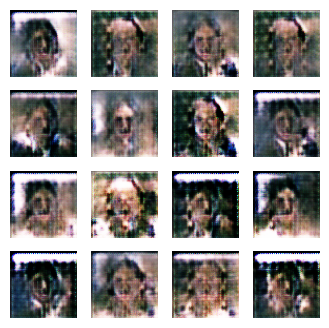

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
generator.save('generator_model.h5')

In [ ]:
# --- Después de entrenar, graficar métricas ---

def plot_metrics():
    epochs_range = range(1, len(d_losses) + 1)

    plt.figure(figsize=(14,5))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, d_losses, label='Pérdida Discriminador')
    plt.plot(epochs_range, g_losses, label='Pérdida Generador')
    plt.xlabel('Batch (iteración)')
    plt.ylabel('Pérdida')
    plt.title('Funciones de pérdida durante el entrenamiento')
    plt.legend()
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(epochs_range, d_accuracies, label='Precisión Discriminador', color='green')
    plt.xlabel('Batch (iteración)')
    plt.ylabel('Precisión')
    plt.title('Precisión del discriminador durante el entrenamiento')
    plt.ylim([0,1])
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

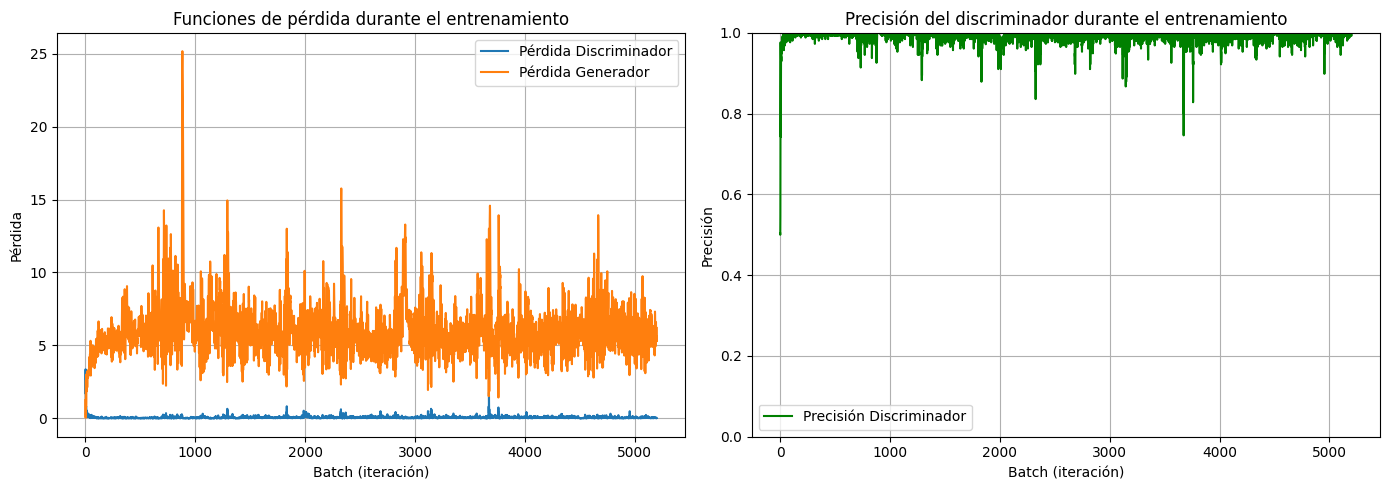

In [ ]:
plot_metrics()

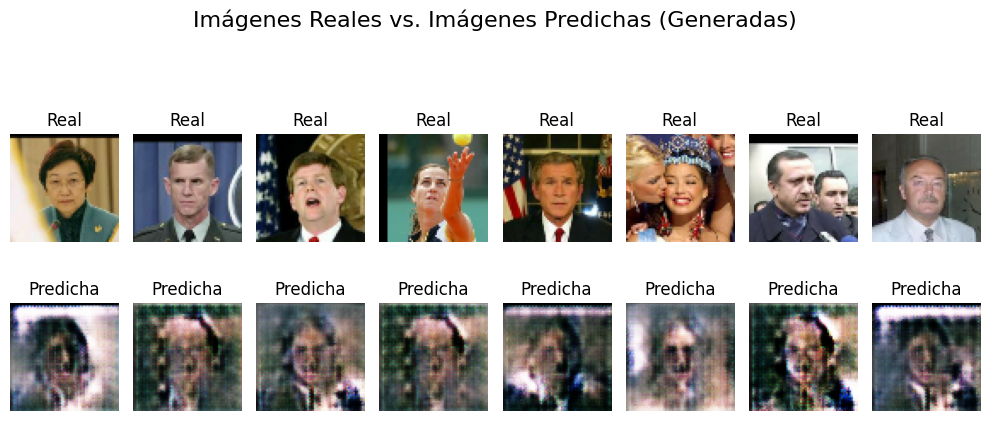

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Tomar un batch de imágenes reales del dataset
real_images_batch = next(iter(train_dataset))

# Generar imágenes falsas usando el generador entrenado
# Usamos la misma semilla que se usó para visualizar el progreso
fake_images = generator(seed, training=False)

# Visualizar algunas imágenes reales y falsas
def display_images(real_imgs, fake_imgs, num_display=16):
    plt.figure(figsize=(10, 5))

    # Mostrar imágenes reales
    for i in range(num_display // 2):
        plt.subplot(2, num_display // 2, i + 1)
        plt.imshow((real_imgs[i] * 127.5 + 127.5).numpy().astype(np.uint8))
        plt.title('Real')
        plt.axis('off')

    # Mostrar imágenes predichas (falsas)
    for i in range(num_display // 2):
        plt.subplot(2, num_display // 2, i + num_display // 2 + 1)
        # Asegurarse de que los valores estén en el rango [0, 255] para visualización
        img_to_display = (fake_imgs[i] * 127.5 + 127.5).numpy()
        img_to_display = np.clip(img_to_display, 0, 255).astype(np.uint8)
        plt.imshow(img_to_display)
        plt.title('Predicha')
        plt.axis('off')

    plt.suptitle('Imágenes Reales vs. Imágenes Predichas (Generadas)', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustar para evitar solapamiento del título
    plt.show()

# Llamar a la función para mostrar las imágenes
# Usamos solo las primeras num_examples_to_generate//2 imágenes reales
display_images(real_images_batch[:num_examples_to_generate//2], fake_images, num_display=num_examples_to_generate)

In [ ]:
import glob
from PIL import Image

# Obtener la lista de archivos de imágenes generadas
generated_image_files = sorted(glob.glob('image_at_epoch_*.png'))

# Mostrar cada imagen generada
for image_file in generated_image_files:
    display.display(Image.open(image_file))


Output hidden; open in https://colab.research.google.com to view.